In [1]:
# Cell 1: Setup (repo root + strict repo-local R library)
source("../setup/r_bootstrap.R")

Repo root: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea 
No issues found -- the project is in a consistent state.
renv is synchronized.
✅ R bootstrap complete.


In [2]:
# Cell 2: Paths + load inputs (from script 01/02 outputs)

# Inputs (canonical)
deg_fp  <- file.path(REPO_ROOT, "results/tables/deg",  "DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma.csv")
expr_fp <- file.path(REPO_ROOT, "data/processed/preprocessing_outputs", "expr_LumA_IDC_Tumor_vs_AllNormals.tsv")
meta_fp <- file.path(REPO_ROOT, "data/processed/preprocessing_outputs", "metadata_LumA_IDC_Tumor_vs_AllNormals.tsv")

stopifnot(file.exists(deg_fp), file.exists(expr_fp), file.exists(meta_fp))

# Outputs (canonical)
deg_tables_dir <- file.path(REPO_ROOT, "results/tables/deg")
deg_fig_dir    <- file.path(REPO_ROOT, "results/figures/deg")
gsea_tables_dir<- file.path(REPO_ROOT, "results/tables/gsea")
gsea_fig_dir   <- file.path(REPO_ROOT, "results/figures/gsea")

dir.create(deg_tables_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(deg_fig_dir,    recursive = TRUE, showWarnings = FALSE)
dir.create(gsea_tables_dir,recursive = TRUE, showWarnings = FALSE)
dir.create(gsea_fig_dir,   recursive = TRUE, showWarnings = FALSE)

annot_fp     <- file.path(deg_tables_dir, "DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma_annotated.csv")
volcano_png  <- file.path(deg_fig_dir,    "Volcano_LumA_IDC_Tumor_vs_AllNormals.png")
heatmap_png  <- file.path(deg_fig_dir,    "Top50_DEGs_Heatmap.png")
heatmap_pdf  <- file.path(deg_fig_dir,    "Top50_DEGs_Heatmap.pdf")
gsea_sum_fp  <- file.path(gsea_tables_dir,"GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv")

# Load DEG table (from 02)
deg <- readr::read_csv(deg_fp, show_col_types = FALSE)

# Standardize expected column names 
if (!("log2FoldChange" %in% names(deg)) && ("logFC" %in% names(deg))) deg$log2FoldChange <- deg$logFC
if (!("padj" %in% names(deg)) && ("adj.P.Val" %in% names(deg))) deg$padj <- deg$`adj.P.Val`
if (!("pvalue" %in% names(deg)) && ("P.Value" %in% names(deg))) deg$pvalue <- deg$`P.Value`

deg <- dplyr::filter(deg, !is.na(padj), !is.na(log2FoldChange))
cat("DEG table loaded:", nrow(deg), "genes\n")

# Load expr/meta (use fread for speed)
expr_dt <- data.table::fread(expr_fp)
gene <- expr_dt[[1]]
expr <- as.matrix(expr_dt[, -1, with=FALSE])
rownames(expr) <- gene

meta <- read.delim(meta_fp, stringsAsFactors = FALSE, check.names = FALSE)

cat("Expression:", nrow(expr), "×", ncol(expr), "\n")
cat("Metadata:", nrow(meta), "×", ncol(meta), "\n")
print(table(meta$Group))

# Align meta to expr columns
stopifnot(all(colnames(expr) %in% meta$Sample))
meta <- meta[match(colnames(expr), meta$Sample), ]
stopifnot(all(meta$Sample == colnames(expr)))

DEG table loaded: 20530 genes
Expression: 20530 × 413 
Metadata: 413 × 5 

Normal  Tumor 
   114    299 


In [3]:
# Cell 3: Annotate and Resave DEG Table

# Thresholds
padj_cutoff <- 0.05
log2fc_cutoff <- 1

# Annotate: -log10(padj) and regulation class
deg$negLog10Padj <- -log10(deg$padj)

deg$Regulation <- "Not Significant"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange >  log2fc_cutoff] <- "Up"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange < -log2fc_cutoff] <- "Down"

deg$Regulation <- factor(deg$Regulation, levels = c("Down","Not Significant","Up"))

cat("DE gene counts (padj <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Save annotated DEG table
write.csv(deg, annot_fp, row.names = FALSE)
cat("Annotated DEG table written to:\n  ", annot_fp, "\n")

DE gene counts (padj < 0.05 , |log2FC| > 1 ):

           Down Not Significant              Up 
           2770           16339            1421 
Annotated DEG table written to:
   /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/tables/deg/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_limma_annotated.csv 


DE gene counts (FDR < 0.05 , |log2FC| > 1 ):

           Down Not Significant              Up 
           2770           16339            1421 
Labeling 50 genes on volcano (top up/down by FDR).
Volcano plot saved: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/deg/Volcano_LumA_IDC_Tumor_vs_AllNormals.png 


# Top 50 Genes Labeled on Volcano Plot


| Rank |Gene       | log2FoldChange |   padj    | Regulation |
|:----:|:----------|:--------------:|:---------:|:----------:|
|  1   |COL10A1    |      7.69      | 4.56e-167 |     Up     |
|  2   |MMP11      |      6.38      | 5.22e-149 |     Up     |
|  3   |NEK2       |      4.12      | 5.82e-108 |     Up     |
|  4   |PPAPDC1A   |      5.40      | 2.65e-106 |     Up     |
|  5   |COL11A1    |      6.71      | 7.52e-104 |     Up     |
|  6   |GABRD      |      3.38      | 2.91e-103 |     Up     |
|  7   |HSD17B6    |      3.14      | 4.24e-103 |     Up     |
|  8   |WISP1      |      3.79      | 6.35e-101 |     

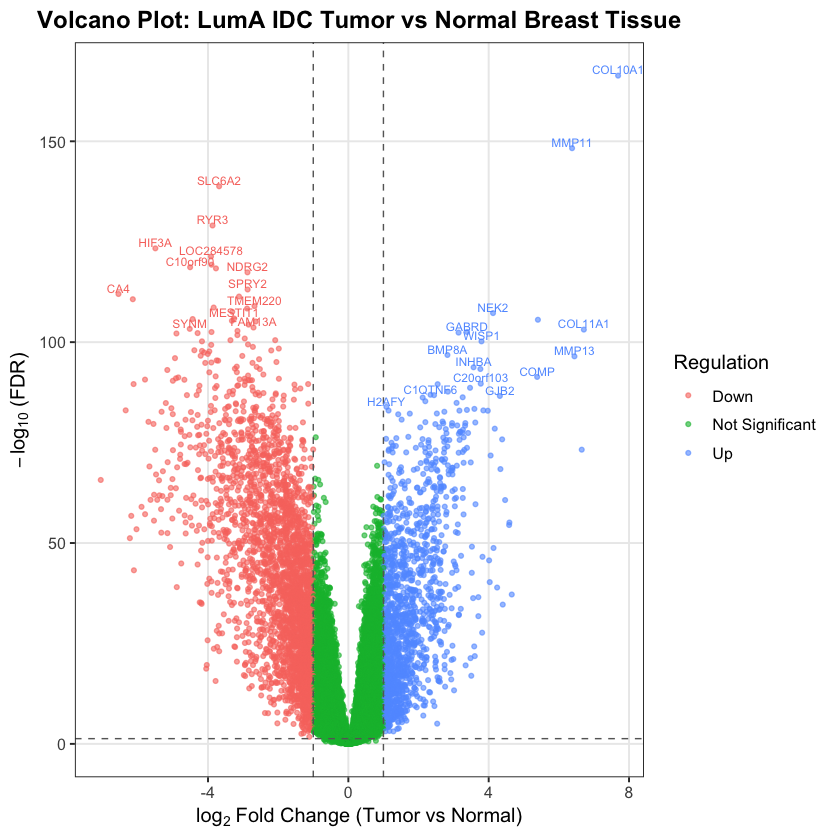

In [4]:
# Cell 4: Volcano plot + labeled table (Top 25 Up/Down)

# Ensure annotation fields exist
padj_cutoff   <- 0.05
log2fc_cutoff <- 1

deg$negLog10Padj <- -log10(deg$padj)

deg$Regulation <- "Not Significant"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange >  log2fc_cutoff] <- "Up"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange < -log2fc_cutoff] <- "Down"
deg$Regulation <- factor(deg$Regulation, levels = c("Down","Not Significant","Up"))

cat("DE gene counts (FDR <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Pick top genes to label
deg_sig_up   <- deg[deg$Regulation == "Up", ]
deg_sig_down <- deg[deg$Regulation == "Down", ]

deg_sig_up   <- deg_sig_up[order(deg_sig_up$padj), ]
deg_sig_down <- deg_sig_down[order(deg_sig_down$padj), ]

n_label_per_side <- 25
top_up   <- deg_sig_up[1:min(n_label_per_side, nrow(deg_sig_up)), ]
top_down <- deg_sig_down[1:min(n_label_per_side, nrow(deg_sig_down)), ]
label_genes <- rbind(top_up, top_down)
n_label <- nrow(label_genes)

cat("Labeling", n_label, "genes on volcano (top up/down by FDR).\n")

# Build plot (fully namespaced = no reliance on library() state)
p <- ggplot2::ggplot(
  deg,
  ggplot2::aes(x = log2FoldChange, y = negLog10Padj, color = Regulation)
) +
  ggplot2::geom_point(alpha = 0.6, size = 1) +
  ggplot2::geom_vline(
    xintercept = c(-log2fc_cutoff, log2fc_cutoff),
    linetype = "dashed", linewidth = 0.4, color = "grey40"
  ) +
  ggplot2::geom_hline(
    yintercept = -log10(padj_cutoff),
    linetype = "dashed", linewidth = 0.4, color = "grey40"
  ) +
  ggplot2::geom_text(
    data = label_genes,
    ggplot2::aes(label = gene),
    size = 2.5,
    vjust = -0.2,
    check_overlap = TRUE,
    show.legend = FALSE
  ) +
  ggplot2::labs(
    title = "Volcano Plot: LumA IDC Tumor vs Normal Breast Tissue",
    x = expression(log[2]~"Fold Change (Tumor vs Normal)"),
    y = expression(-log[10]~"(FDR)"),
    color = "Regulation"
  ) +
  ggplot2::theme_bw(base_size = 12) +
  ggplot2::theme(
    plot.title = ggplot2::element_text(hjust = 0.5, face = "bold"),
    panel.grid.minor = ggplot2::element_blank()
  )

ggplot2::ggsave(volcano_png, p, width = 8, height = 5, dpi = 300)
cat("Volcano plot saved:", volcano_png, "\n")
print(p)

# Print a small labeled table in notebook output (fully namespaced)
if (!requireNamespace("knitr", quietly = TRUE)) install.packages("knitr", repos = "https://cloud.r-project.org")
table_data <- data.frame(
  Rank = 1:n_label,
  Gene = label_genes$gene,
  log2FoldChange = round(label_genes$log2FoldChange, 2),
  padj = formatC(label_genes$padj, format = "e", digits = 2),
  Regulation = label_genes$Regulation,
  stringsAsFactors = FALSE
)

cat("\n\n")
cat("# Top", n_label, "Genes Labeled on Volcano Plot\n")
print(knitr::kable(table_data, align = c("c","l","c","c","c")))

In [ ]:
# Cell 5: Merge GSEA reports (auto-detect latest pos/neg report per DB) + robust column normalization
# NOTE: GSEA report TSVs are committed to repo as frozen analysis artifacts

GSEA_ROOT <- file.path(REPO_ROOT, "data", "GSEA_output")

latest_report <- function(dir_path, pattern) {
  if (!dir.exists(dir_path)) stop("GSEA directory does not exist: ", dir_path)
  files <- list.files(dir_path, pattern = pattern, full.names = TRUE)
  if (length(files) == 0) stop("No files found in ", dir_path, " matching ", pattern)
  files[which.max(file.info(files)$mtime)]
}

normalize_gsea_cols <- function(df) {
  # drop blank/unnamed columns created by GSEA exports (e.g., ...12)
  unnamed <- grepl("^\\.\\.\\.[0-9]+$", names(df))
  if (any(unnamed)) df <- df[, !unnamed, drop = FALSE]

  # Map common GSEA column variants -> canonical
  n <- names(df)

  # NAME
  if (!("NAME" %in% n)) {
    cand <- n[grepl("^NAME$|^pathway$|^geneset$|^GS\\b|^GS_NAME$", n, ignore.case = TRUE)]
    if (length(cand)) names(df)[match(cand[1], n)] <- "NAME"
  }

  # NES
  if (!("NES" %in% n)) {
    cand <- n[grepl("^NES$", n, ignore.case = TRUE)]
    if (length(cand)) names(df)[match(cand[1], n)] <- "NES"
  }

  # FDR.q.val (GSEA often uses "FDR q-val")
  if (!("FDR.q.val" %in% names(df))) {
    cand <- names(df)[grepl("^FDR\\s*q-?val$|^FDR\\.q\\.val$", names(df), ignore.case = TRUE)]
    if (length(cand)) names(df)[match(cand[1], names(df))] <- "FDR.q.val"
  }

  df
}

load_gsea_reports <- function(db_dir, db_name) {
  pos_fp <- latest_report(db_dir, "^gsea_report_for_na_pos_.*\\.tsv$")
  neg_fp <- latest_report(db_dir, "^gsea_report_for_na_neg_.*\\.tsv$")

  pos <- read.delim(pos_fp, stringsAsFactors = FALSE, check.names = FALSE)
  pos <- normalize_gsea_cols(pos)
  pos$direction <- "Up_in_Tumor"
  pos$Database  <- db_name

  neg <- read.delim(neg_fp, stringsAsFactors = FALSE, check.names = FALSE)
  neg <- normalize_gsea_cols(neg)
  neg$direction <- "Down_in_Tumor"
  neg$Database  <- db_name

  rbind(pos, neg)
}

gsea_legacy   <- load_gsea_reports(file.path(GSEA_ROOT, "KEGG-Legacy"),  "KEGG_Legacy")
gsea_medicus  <- load_gsea_reports(file.path(GSEA_ROOT, "KEGG-Medicus"), "KEGG_Medicus")
gsea_hallmark <- load_gsea_reports(file.path(GSEA_ROOT, "Hallmark-All"), "Hallmark")

gsea_all <- dplyr::bind_rows(gsea_legacy, gsea_medicus, gsea_hallmark)

if (!("NES" %in% names(gsea_all))) stop("Expected column 'NES' not found. Columns are: ", paste(names(gsea_all), collapse = ", "))
gsea_all <- gsea_all[order(-gsea_all$NES), ]

write.csv(gsea_all, gsea_sum_fp, row.names = FALSE)
cat("Wrote combined GSEA summary:", gsea_sum_fp, "\n")

want <- c("NAME", "Database", "NES", "direction")
have <- intersect(want, names(gsea_all))

preview <- gsea_all[, have, drop = FALSE]
print(head(preview, 15), row.names = FALSE)

New names:
• `` -> `...12`
New names:
• `` -> `...12`
New names:
• `` -> `...12`


Wrote combined GSEA summary: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/tables/gsea/GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv 
                                                                                               NAME
                                                                               HALLMARK_E2F_TARGETS
                                                                            HALLMARK_G2M_CHECKPOINT
                                                                            HALLMARK_MYC_TARGETS_V1
                                                                               KEGG_DNA_REPLICATION
                                             KEGG_MEDICUS_REFERENCE_ORIGIN_UNWINDING_AND_ELONGATION
                                                                                    KEGG_PROTEASOME
   KEGG_MEDICUS_VARIANT_MUTATION_CAUSED_ABERRANT_HTT_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION
                                         

Saved waterfall plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/gsea/GSEA_Waterfall_Hallmark.png 
Saved waterfall plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/gsea/GSEA_Waterfall_KEGG_Legacy.png 


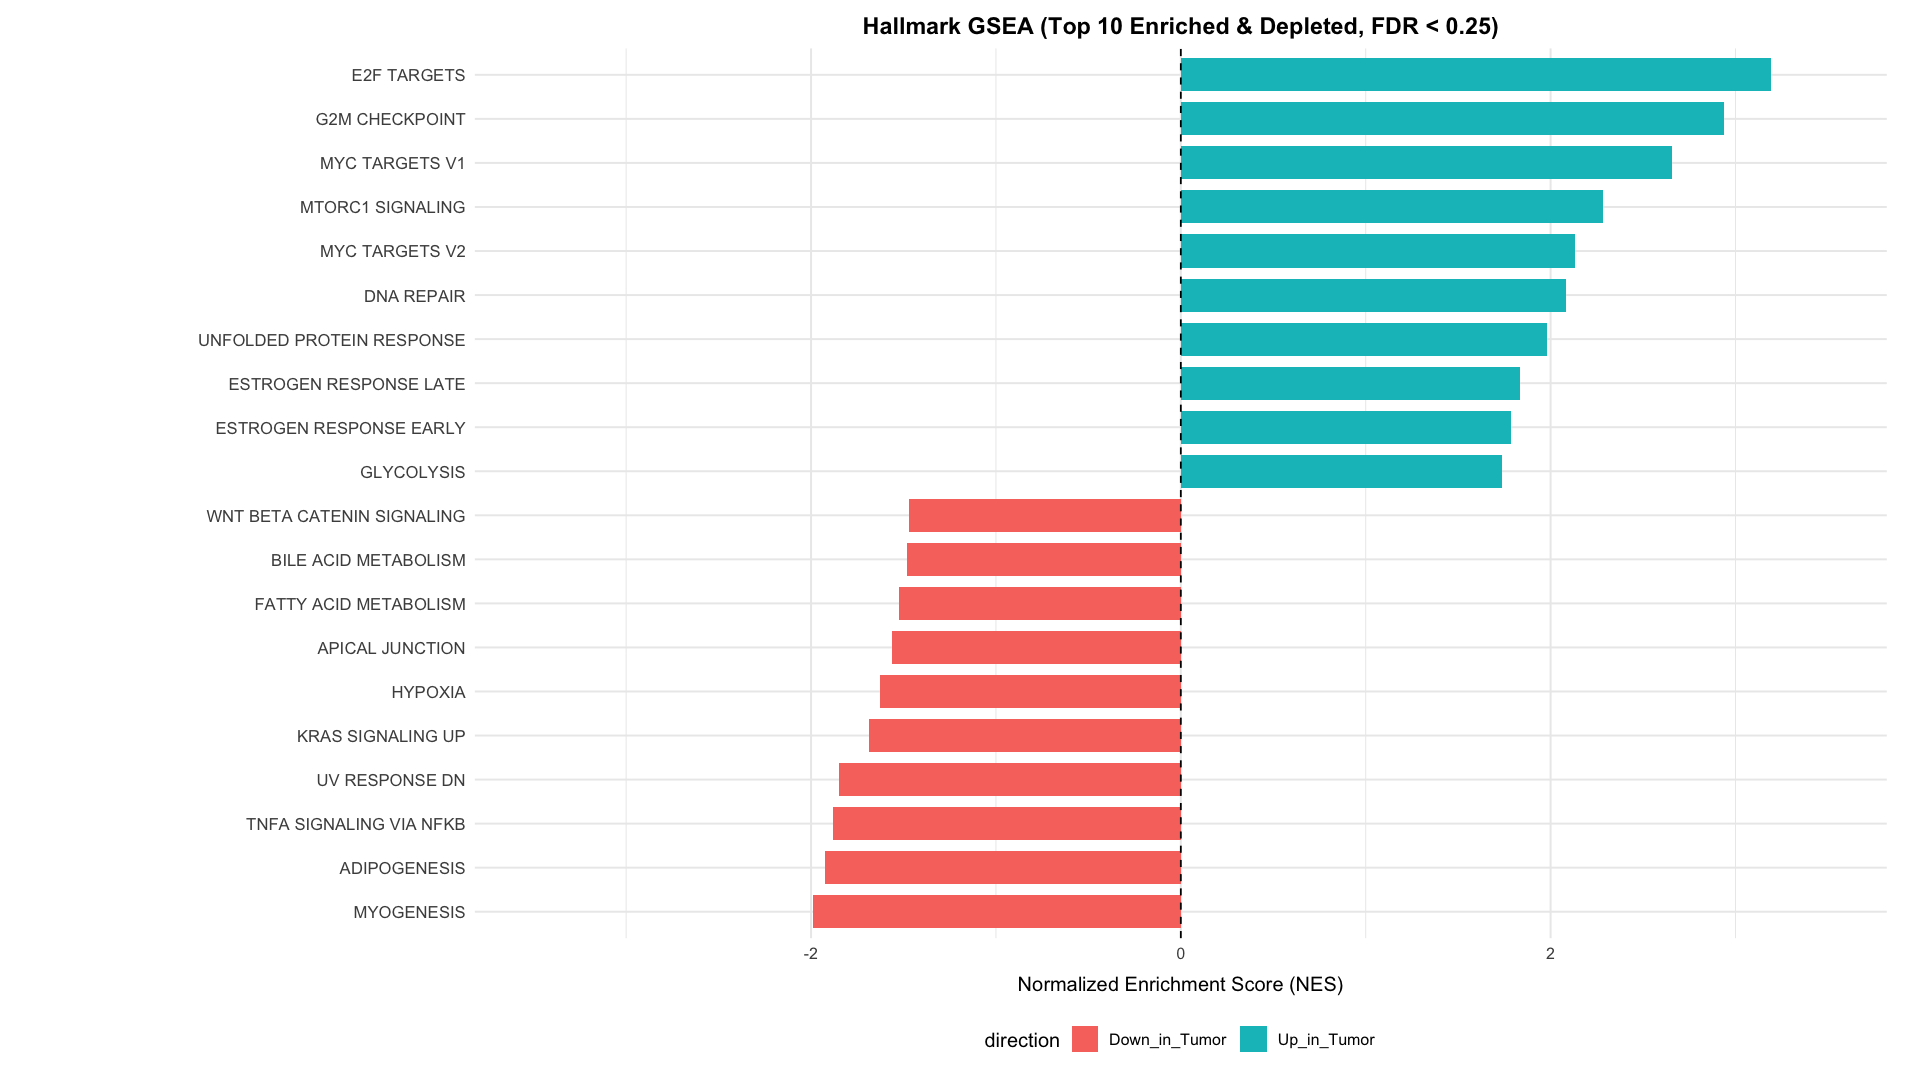

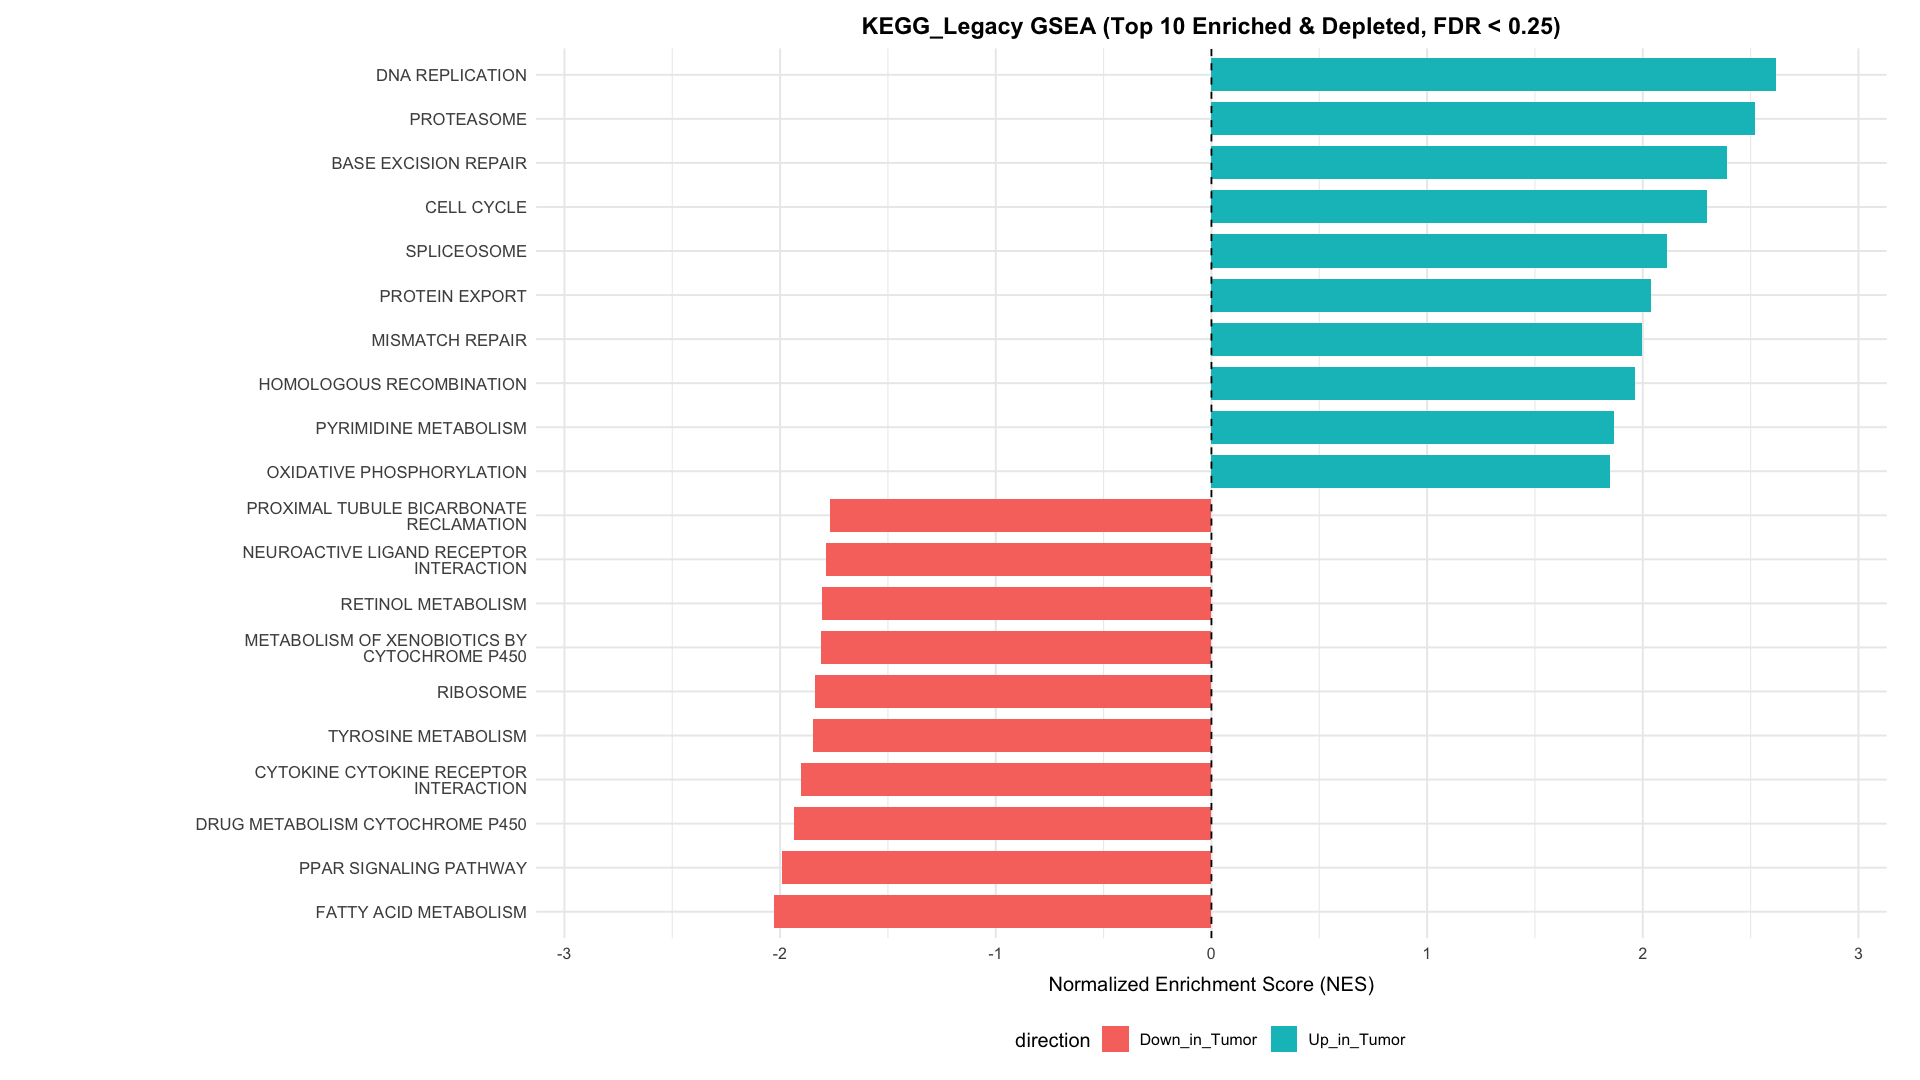

Saved waterfall plot: /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/gsea/GSEA_Waterfall_KEGG_Medicus.png 
All waterfall plots complete.


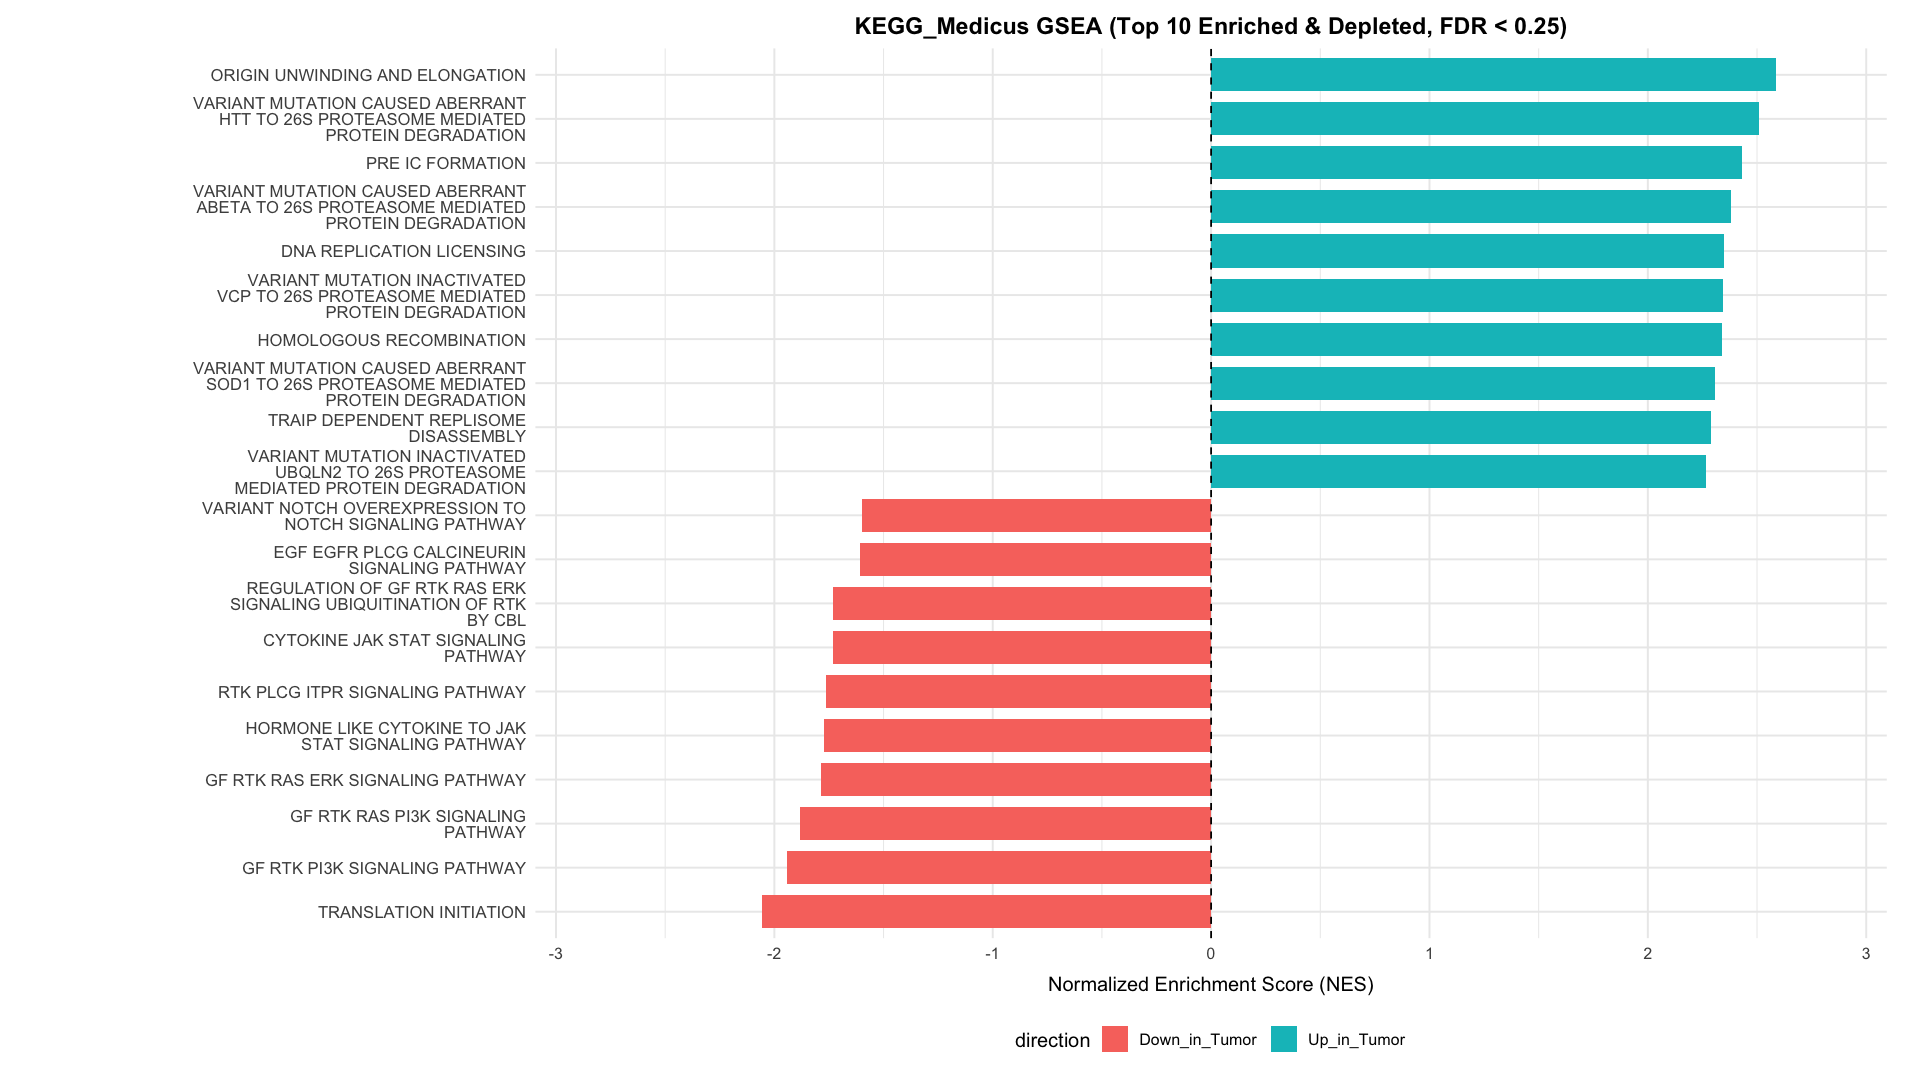

In [6]:
# Cell 6: GSEA waterfall plots (Top enriched + depleted, FDR < 0.25) — robust for long Medicus names

suppressPackageStartupMessages({
  library(ggplot2)
  library(dplyr)
})

if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr", lib = RLIBS)
suppressPackageStartupMessages(library(stringr))

databases_to_plot <- unique(gsea_all$Database)

clean_pathway <- function(x) {
  x <- toupper(x)
  x <- gsub("^HALLMARK_", "", x)
  x <- gsub("^KEGG_", "", x)
  x <- gsub("^MEDICUS_", "", x)
  x <- gsub("^MEDICUS\\s+", "", x)
  x <- gsub("^REFERENCE\\s+", "", x)
  x <- gsub("^REFERENCE_", "", x)
  x <- gsub("^PATHWAY\\s+", "", x)
  x <- gsub("_", " ", x)
  x <- gsub("\\s+", " ", x)
  trimws(x)
}

for (db_name in databases_to_plot) {

  gsea_db_sig <- gsea_all %>%
    filter(Database == db_name, `FDR.q.val` < 0.25)

  if (nrow(gsea_db_sig) == 0) {
    cat("No significant pathways for", db_name, "(FDR<0.25). Skipping.\n")
    next
  }

  
  # n_each <- 10
    n_each <- 10
  gsea_up <- gsea_db_sig %>%
    filter(direction == "Up_in_Tumor") %>%
    arrange(desc(NES)) %>%
    slice_head(n = n_each)

  gsea_down <- gsea_db_sig %>%
    filter(direction == "Down_in_Tumor") %>%
    arrange(NES) %>%
    slice_head(n = n_each)

  gsea_combined <- bind_rows(gsea_up, gsea_down)

  if (nrow(gsea_combined) == 0) {
    cat("No pathways after filtering for", db_name, ". Skipping.\n")
    next
  }

  # Clean + wrap + cap labels (prevents labels from stealing the whole plot)
  gsea_combined$SHORT_NAME <- clean_pathway(gsea_combined$NAME)
  gsea_combined$SHORT_NAME <- stringr::str_wrap(gsea_combined$SHORT_NAME, width = 32)
  gsea_combined$SHORT_NAME <- ifelse(
    nchar(gsea_combined$SHORT_NAME) > 120,
    paste0(substr(gsea_combined$SHORT_NAME, 1, 117), "..."),
    gsea_combined$SHORT_NAME
  )

  # Reorder AFTER wrapping so plot order matches NES
  gsea_combined$SHORT_NAME <- factor(
    gsea_combined$SHORT_NAME,
    levels = gsea_combined$SHORT_NAME[order(gsea_combined$NES)]
  )

  # Force symmetric NES limits so bars remain visible
  lim <- max(abs(gsea_combined$NES), na.rm = TRUE)
  lim <- max(lim, 1)
  y_lim <- lim * 1.15

  p_waterfall <- ggplot(gsea_combined, aes(x = SHORT_NAME, y = NES, fill = direction)) +
    geom_col(width = 0.75) +
    coord_flip(clip = "off") +
    geom_hline(yintercept = 0, linetype = "dashed", linewidth = 0.5) +
    scale_y_continuous(limits = c(-y_lim, y_lim), expand = expansion(mult = c(0.02, 0.02))) +
    labs(
      title = paste0(db_name, " GSEA (Top ", n_each, " Enriched & Depleted, FDR < 0.25)"),
      x = NULL,
      y = "Normalized Enrichment Score (NES)"
    ) +
    theme_minimal(base_size = 12) +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
      axis.text.y = element_text(size = 10, lineheight = 0.8),
      axis.title.y = element_blank(),
      axis.title.x = element_text(margin = margin(t = 8)),
      legend.position = "bottom",
      # Large left margin is essential for wrapped Medicus labels
      plot.margin = margin(10, 20, 10, 120)
    )

  out_png_waterfall <- file.path(gsea_fig_dir, paste0("GSEA_Waterfall_", db_name, ".png"))

  ggsave(out_png_waterfall, p_waterfall,
         width = 16, height = 9, units = "in", dpi = 300,
         limitsize = FALSE, bg = "white")

  options(repr.plot.width = 16, repr.plot.height = 9)
  print(p_waterfall)

  cat("Saved waterfall plot:", out_png_waterfall, "\n")
}

cat("All waterfall plots complete.\n")
options(repr.plot.width = 7, repr.plot.height = 4)

In [7]:
# Cell 7: Heatmap prep (Top 25 up + Top 25 down by FDR) + aligned metadata

deg_sig <- deg[deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]

deg_up   <- deg_sig[deg_sig$log2FoldChange > 0, ]
deg_down <- deg_sig[deg_sig$log2FoldChange < 0, ]

deg_up   <- deg_up[order(deg_up$padj), ][1:min(25, nrow(deg_up)), ]
deg_down <- deg_down[order(deg_down$padj), ][1:min(25, nrow(deg_down)), ]

genes_top <- unique(c(deg_up$gene, deg_down$gene))
genes_top <- genes_top[genes_top %in% rownames(expr)]

cat("Heatmap includes", length(genes_top), "genes.\n")
stopifnot(length(genes_top) > 1)

expr_sub <- expr[genes_top, , drop = FALSE]

# Z-score per gene (row)
expr_scaled <- t(scale(t(expr_sub)))
expr_scaled[is.na(expr_scaled)] <- 0  # handle any constant rows safely

# Align metadata to expression columns 
stopifnot(all(c("Sample", "Group") %in% colnames(meta)))

meta_sub <- meta[match(colnames(expr_scaled), meta$Sample), , drop = FALSE]
rownames(meta_sub) <- meta_sub$Sample

stopifnot(all(rownames(meta_sub) == colnames(expr_scaled)))

cat("Metadata aligned:", nrow(meta_sub), "samples.\n")

Heatmap includes 50 genes.
Metadata aligned: 413 samples.


Loading required package: grid

ComplexHeatmap version 2.26.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.17
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

pdf 
  2

pdf 
  2

Saved heatmap:
   /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/deg/Top50_DEGs_Heatmap.png 
   /Users/tommyrucinski/dev/repos/tcga-brca-luminalA-deg-gsea/results/figures/deg/Top50_DEGs_Heatmap.pdf 


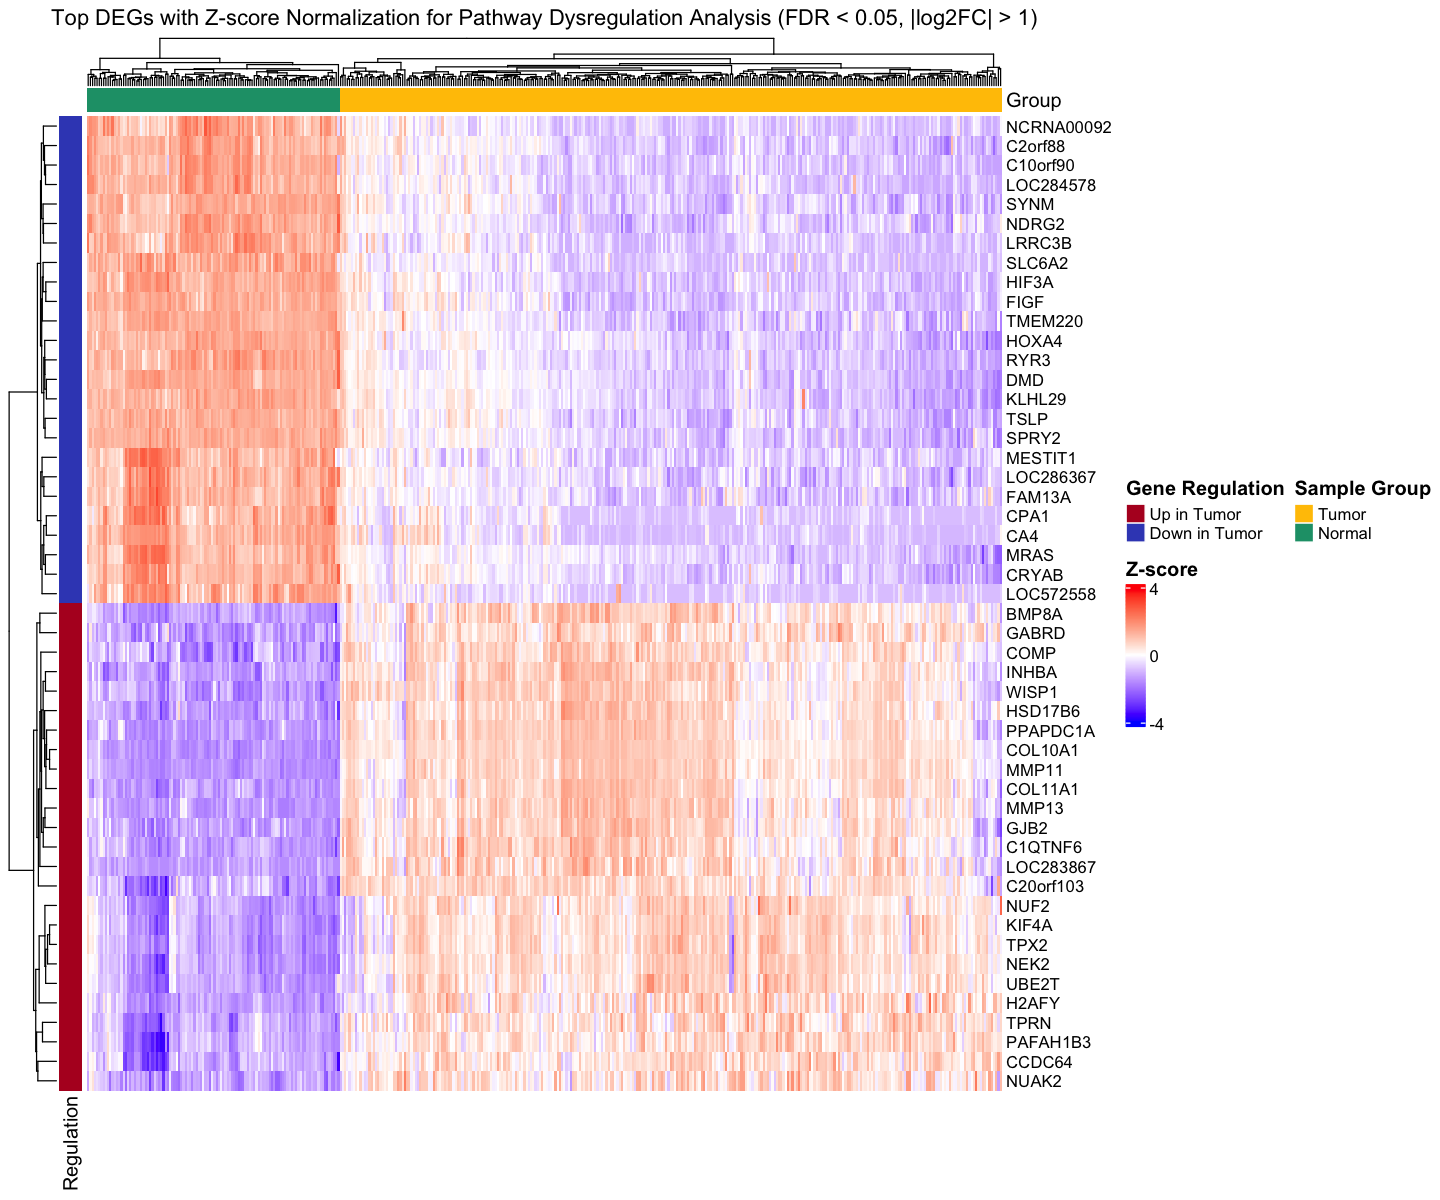

In [8]:
# Cell 8: Generate and Save Heatmap 

library(ComplexHeatmap)
library(circlize)
library(grid)

# ------------------------
# Define Colors
# ------------------------
SAMPLE_TUMOR_COLOR     <- "#FFC300" # Yellow/Gold
SAMPLE_NORMAL_COLOR    <- "#1B9E77" # Teal/Green
REGULATION_UP_COLOR    <- "#B40426" # Red
REGULATION_DOWN_COLOR  <- "#3B4CC0" # Blue

# ------------------------
# Define Annotations
# ------------------------
# meta_sub must be aligned to expr_scaled columns (same order)
sample_group <- meta_sub$Group
names(sample_group) <- rownames(meta_sub)

ha_col <- HeatmapAnnotation(
  Group = sample_group,
  col = list(Group = c("Tumor" = SAMPLE_TUMOR_COLOR, "Normal" = SAMPLE_NORMAL_COLOR)),
  annotation_legend_param = list(
    Group = list(
      title = "Sample Group",
      title_gp = gpar(fontface = "bold"),
      at = c("Tumor", "Normal"),
      labels = c("Tumor", "Normal")
    )
  )
)

row_reg <- ifelse(rownames(expr_scaled) %in% deg_up$gene, "Up_in_Tumor", "Down_in_Tumor")

ha_row <- rowAnnotation(
  Regulation = row_reg,
  col = list(Regulation = c("Up_in_Tumor" = REGULATION_UP_COLOR, "Down_in_Tumor" = REGULATION_DOWN_COLOR)),
  annotation_legend_param = list(
    Regulation = list(
      title = "Gene Regulation",
      title_gp = gpar(fontface = "bold"),
      at = c("Up_in_Tumor", "Down_in_Tumor"),
      labels = c("Up in Tumor", "Down in Tumor")
    )
  )
)

# ------------------------
# Heatmap Construction
# ------------------------
EXPR_COLORS <- colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))

h <- Heatmap(
  expr_scaled,
  name = "Z-score",
  col = EXPR_COLORS,
  top_annotation = ha_col,
  left_annotation = ha_row,
  show_row_names = TRUE,
  show_column_names = FALSE,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  row_names_gp = gpar(fontsize = 10),
  column_title = "Top DEGs with Z-score Normalization for Pathway Dysregulation Analysis (FDR < 0.05, |log2FC| > 1)",
  heatmap_legend_param = list(
    title = "Z-score",
    title_gp = gpar(fontface = "bold"),
    at = c(-4, 0, 4),
    labels = c("-4", "0", "4"),
    legend_height = unit(3, "cm")
  )
)

# ------------------------
# Ensure output directory exists
# ------------------------
dir.create(dirname(heatmap_png), recursive = TRUE, showWarnings = FALSE)
dir.create(dirname(heatmap_pdf), recursive = TRUE, showWarnings = FALSE)

# ------------------------
# Save as PNG 
# ------------------------
png(heatmap_png, width = 2000, height = 1500, res = 200)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

# ------------------------
# Save as PDF 
# ------------------------
pdf(heatmap_pdf, width = 12, height = 10)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

# ------------------------
# Display in notebook with explicit device size 
# ------------------------
options(repr.plot.width = 12, repr.plot.height = 10)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")

cat("Saved heatmap:\n  ", heatmap_png, "\n  ", heatmap_pdf, "\n")

In [9]:
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: aarch64-apple-darwin24.4.0
Running under: macOS Sequoia 15.6.1

Matrix products: default
BLAS:   /opt/homebrew/Cellar/openblas/0.3.30/lib/libopenblasp-r0.3.30.dylib 
LAPACK: /opt/homebrew/Cellar/r/4.5.2_1/lib/R/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] circlize_0.4.17       ComplexHeatmap_2.26.0 stringr_1.6.0        
[4] dplyr_1.1.4           ggplot2_4.0.1        

loaded via a namespace (and not attached):
 [1] generics_0.1.4      renv_1.1.5          shape_1.4.6.1      
 [4] stringi_1.8.7       hms_1.1.4           digest_0.6.39      
 [7] magrittr_2.0.4      evaluate_1.0.5      RColorBrewer_1.1-3 
[10] pbdZMQ_0.3-14       iterators_1.0.14    fastmap_1.2.0      
[13] foreach_